[<img src="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" width="200" align='right'>](https://www.tudelft.nl/citg/over-faculteit/afdelingen/geoscience-remote-sensing/staff/scientific-staff/dr-stef-lhermitte)


# CS4305TU: Week 7 - Convolutional Neural Networks - Assignment
## Renote sensing classification using CNNs
*14 & 18 Nov 2021*

*Created by Stef Lhermitte (s.lhermitte at tudelft.nl / [@steflhermitte](https://twitter.com/StefLhermitte) | www.earthmapps.io)*

[![Twitter](https://img.shields.io/twitter/url/https/twitter.com/cloudposse.svg?style=social&label=%20%40steflhermitte)](https://twitter.com/steflhermitte)

---


# Notebook instructions
 
In assignment 7 on CNNs you will work on landcover classification of Sentinel-2 satellite image patches using:
 * ANNs (Step 1)
 * CNNs (Step 2) 
 * Transfer learning (Step3) 
 
and instance segmentation of impervious surface from Landsat-8 satellite images using:
 * U-nets (Step 4)
 
To do the analysis and answer the questions, you can draw a lot form the snippets of codes we used in the example notebook. We ask you to train each model for only 5 epochs. Off course you are free to run more (and it would increase performance), but 5 should already be good enough to see the tendencies to interpret the questions). Moreover, I strongly recommend to start the notebook with GPU-accelerator. Otherwise, training might take very long.

For each of the steps, there is :
 * a short introduction in markdown which you should remove from the notebook you hand-in
 * a set of questions marked with `[code]` where we ask you to write code to do the required steps
 * a set of questions marked with `[text]` where we ask you to respond to the question with written text in a markdown cell

## Submission instructions

- Answer the questions (code and/or text) in this notebook
- Rename this file by adding your group nomber (e.g. Assignment_groupXX.ipynb)
- Submit your assignment in 3 ways:
 - .ipynb notebook (*File->Download*)
 - pdf print (*File->Print->Save as pdf*) 
 - a link to your colab notebook (*Share->Get Link*) and make sure you change the settings to *\"Anyone on the internet with this link can view\"*
 

# Q1-3: classification of the eurosat dataset

In step 1-3, we ask you to do a classification on the `eurosat/rgb` dataset and you can find more information about it at the corresponding [keras datasets page](https://www.tensorflow.org/datasets/catalog/eurosat).

You can simply load the data where we split the data into 75/25\% training/validation.

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
ds_train, info = tfds.load('eurosat/rgb', split='train[:75%]', as_supervised=True, shuffle_files=True, with_info=True)
ds_val, info = tfds.load('eurosat/rgb', split='train[75%:]', as_supervised=True, shuffle_files=False, with_info=True)
test_images=ds_val

The result is a tdfs.DataSet over which you can iterate and modify etc. You can find more info on the [DataSet help page](https://www.tensorflow.org/datasets/overview#iterate_over_a_dataset), but here is already a simple example to load one example to load it for visualization:

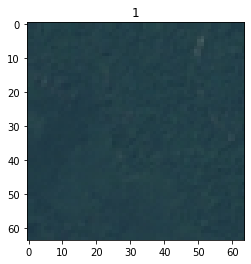

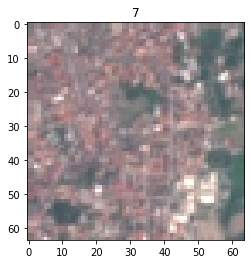

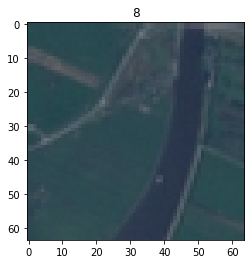

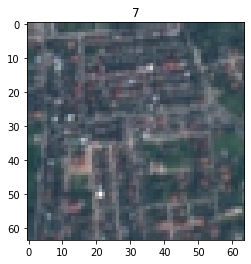

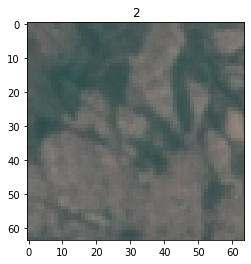

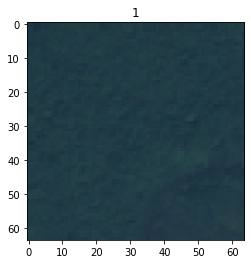

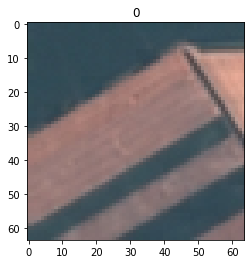

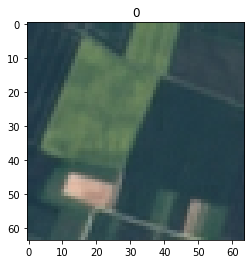

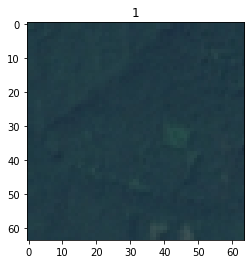

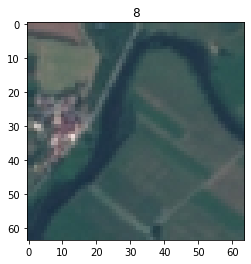

In [2]:
import numpy as np
import matplotlib.pyplot as plt

temp = ds_train.take(10).as_numpy_iterator()
for i in temp:
  plt.figure()
  plt.imshow(i[0])
  plt.title(i[1])

Or by using the built-in `tfds.show_examples` function:

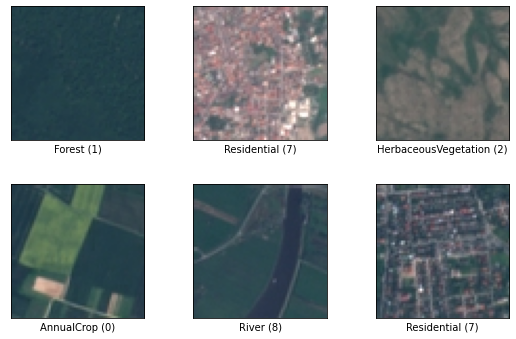

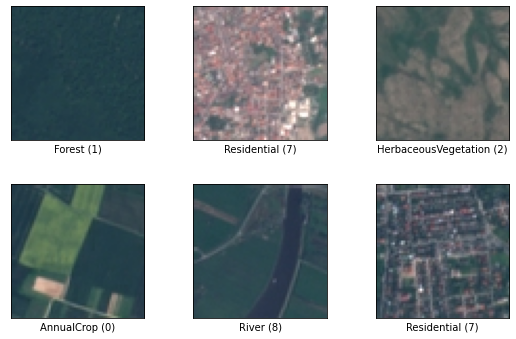

In [3]:
tfds.show_examples(ds_train.take(6), info)

When loading the data into your network, you probably need to cache, batch and prefetch them to increase [performance](https://www.tensorflow.org/guide/data_performance#prefetching). In this case, you should not worry about it and just run it after loading the data

In [4]:
ds_train = ds_train.cache()
ds_train = ds_train.batch(128)
ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.batch(128)
ds_val = ds_val.cache()
ds_val.prefetch(tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.uint8, tf.int64)>

After this, the data can go directly into the `model.fit()` function with `model.fit(ds_train, epochs=5, batch_size=128, validation_data=ds_val)`

## Q1.1: ANN
 - `[code]` build a classical ANN to classify these Eurosat images with the following characteristics (where `FC[x,y]` = fully-connected layers with `x` neurons and `y` activation): `input->FC[100, relu]->FC[10, relu]->FC[10]` and train it for 5 epochs to classify eurosat dataset.
 - `[code]` make a plot with two subpanels that shows the loss (panel 1) and accuracy (panel 2) for both training and validation datasets
 - `[code]` plot some images (e.g. 5) with the true and predicted label to illustrate the performance of the model
 - `[text]` shortly (max 5 sentences) explain which loss function you implemented for training the network and why
 

To do the predictions you probably need to run a batch of the data. Since it may be difficult if you have limited `tf` experience to access the image, label afterwaterds, I have provided an example below that should clarify it:

Epoch 1/5
159/159 [==============================] - 5s 16ms/step - loss: 4.6601 - accuracy: 0.2046 - val_loss: 5.6896 - val_accuracy: 0.1241
Epoch 2/5
159/159 [==============================] - 2s 13ms/step - loss: 3.2149 - accuracy: 0.2865 - val_loss: 3.7791 - val_accuracy: 0.2953
Epoch 3/5
159/159 [==============================] - 2s 13ms/step - loss: 2.8566 - accuracy: 0.3196 - val_loss: 2.7629 - val_accuracy: 0.3228
Epoch 4/5
159/159 [==============================] - 2s 14ms/step - loss: 3.9858 - accuracy: 0.2444 - val_loss: 4.2024 - val_accuracy: 0.2093
Epoch 5/5
159/159 [==============================] - 2s 13ms/step - loss: 3.5410 - accuracy: 0.2664 - val_loss: 3.8678 - val_accuracy: 0.2766
Training complete


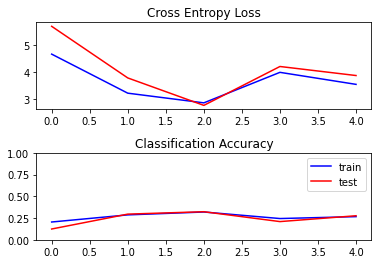

In [5]:
from keras.layers import Dense, Flatten
import keras
from keras.layers import BatchNormalization


model = tf.keras.models.Sequential()
model.add(Flatten(input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(10))
model.add(BatchNormalization())
batch_size = 128 # number of samples processed before the model is updated
num_epochs = 5  # number of complete passes through the training dataset before the training stops

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

history = model.fit(ds_train, epochs=num_epochs, batch_size=batch_size, validation_data=ds_val)
#model.summary()
print('Training complete')

# plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='test')
ace=history.history['loss']
bce=history.history['val_loss']
#plt.ylim(0,2)
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='test')
cce=history.history['accuracy']
dce=history.history['val_accuracy']
plt.ylim(0,1)
# add legend
plt.legend()
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.5)

In [6]:
# Get a batch of validation data
get_batch = ds_val.take(1)
# Convert it to a numpy iterator
get_batch_np = list(get_batch.as_numpy_iterator())
# Do prediction
pred_batch = model.predict(get_batch,batch_size=128)
# Print the size to get understanding of how it looks like
print('Size of pred_batch',pred_batch.shape)
# Get the cell with the maximum prediction
pred_batch_max = np.argmax(pred_batch,axis=1) 
print('Size of pred_batch',pred_batch_max.shape)
# Get the maximum probability
pred_batch_max_prob = pred_batch[:,pred_batch_max[0]] 
print('Size of pred_batch_prob',pred_batch_max_prob.shape)
# Now loop over for example 5 images:
for i in range(5):
  im = get_batch_np[0][0][i,:,:,:]
  label = get_batch_np[0][1][i]
  pred_label = pred_batch_max[i]
  pred_prob = pred_batch_max_prob[i]

Size of pred_batch (128, 10)
Size of pred_batch (128,)
Size of pred_batch_prob (128,)


## Q2.1: CNN
* `[code]` build a CNN to classify these Eurosat images during 5 epochs with the following characteristics where:
 *  `CNN[x*x,y,z,pad, act]` = Conv2D layers with a `x*x` kernel size, `y` filters, `z` stride, `pad` padding and `act` activation) 
 * `MaxPool[x*x,pad]`: MaxPool layer with a `x*x` pool_size and `pad` padding
 * `input -> block 1 -> block 2 -> block 3 -> FC block`, where
   * Block 1: `CNN[5*5,25,1,'same','relu]->MaxPool[2*2,'same']`
   * Block 2: `CNN[5*5,50,1,'same','relu]->CNN[3*3,50,1,'same','relu]->MaxPool[2*2,'same']`
   * Block 3: `CNN[3*3,70,2,'same','relu]->CNN[3*3,50,1,'same','relu]->MaxPool[2*2,'same']`
   * FC block: `FC[100, relu]->FC[10, relu]->FC[10]`
* `[code]` make a plot with two subpanels that shows the loss (panel 1) and accuracy (panel 2) for both training and validation datasets for both the ANN (Q1.1)and CNN (Q2.1)
* `[code]` plot some images (e.g. 5) with the true and predicted label to illustrate the performance of the model
* `[text]` shortly discuss the difference between the ANN and CNN in terms of accuracy, learning rate, overfitting risk and difference in architecture (e.g. number of trainable parameters, layers, ...)
* `[text]` shortly discuss what would be the effect of replacing the `5*5` kernel sizes of block 1+2 by a sequence of 2 `3*3` filters in terms of receptive fields and trainable parameters
* `[text]` shortly discuss what would be the effect of batch normalisation at the end of every block on generalization and overfitting

In [13]:
# Define the convolutinal part of the model architecture using Keras Layers in a sequential model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=25,strides=(1, 1),input_shape=(64,64,3), kernel_size=(5, 5), activation=tf.nn.relu, padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=50,strides=(1, 1),kernel_size=(5, 5), activation=tf.nn.relu, padding='same'))
model.add(tf.keras.layers.Conv2D(filters=50,strides=(1, 1),kernel_size=(3, 3), activation=tf.nn.relu, padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=70,strides=(1, 1),kernel_size=(3,3), activation=tf.nn.relu, padding='same'))
model.add(tf.keras.layers.Conv2D(filters=50,strides=(1, 1),kernel_size=(3, 3), activation=tf.nn.relu, padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 25)        1900      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 25)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 50)        31300     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 50)        22550     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 50)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 70)        31570     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 50)       

In [14]:
batch_size = 128 # number of samples processed before the model is updated
num_epochs = 5  # number of complete passes through the training dataset before the training stops

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

history = model.fit(ds_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=ds_val)
print('Training complete')
CNN_history = history

Epoch 1/5
159/159 [==============================] - 12s 70ms/step - loss: 2.0792 - accuracy: 0.2155 - val_loss: 1.7071 - val_accuracy: 0.3573
Epoch 2/5
159/159 [==============================] - 11s 69ms/step - loss: 1.4337 - accuracy: 0.4664 - val_loss: 1.1121 - val_accuracy: 0.6173
Epoch 3/5
159/159 [==============================] - 11s 70ms/step - loss: 1.2154 - accuracy: 0.5693 - val_loss: 1.0533 - val_accuracy: 0.6396
Epoch 4/5
159/159 [==============================] - 11s 70ms/step - loss: 1.0531 - accuracy: 0.6356 - val_loss: 0.8827 - val_accuracy: 0.6730
Epoch 5/5
159/159 [==============================] - 11s 70ms/step - loss: 0.9704 - accuracy: 0.6631 - val_loss: 0.8659 - val_accuracy: 0.6893
Training complete


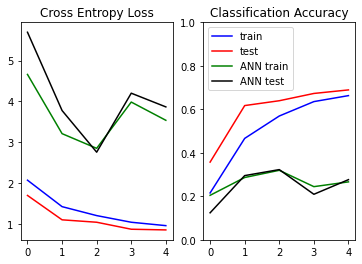

In [15]:
# plot loss
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='test')
plt.plot(ace, color='green', label='ANN train')
plt.plot(bce, color='black', label='ANN test')
# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='test')
plt.plot(cce, color='green', label='ANN train')
plt.plot(dce, color='black', label='ANN test')
plt.ylim(0,2)
plt.ylim(0,1)
# add legend
plt.legend()
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.5)

Size of pred_batch (128, 10)
Size of pred_batch (128,)
Size of pred_batch_prob (128,)


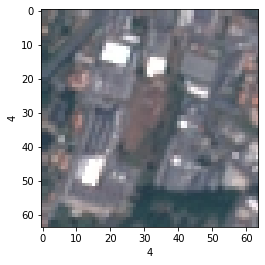

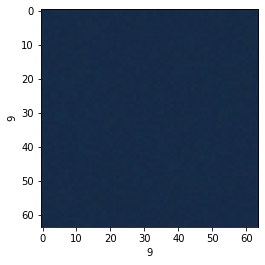

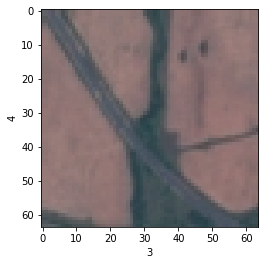

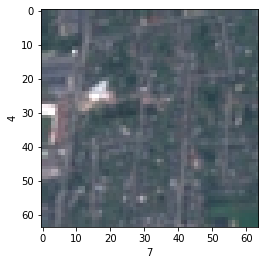

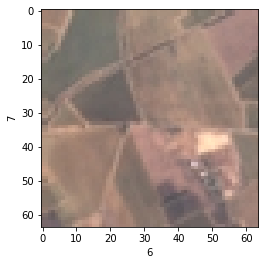

In [10]:
# Get a batch of validation data
get_batch = ds_val.take(1)
# Convert it to a numpy iterator
get_batch_np = list(get_batch.as_numpy_iterator())
# Do prediction
pred_batch = model.predict(get_batch,batch_size=128)
# Print the size to get understanding of how it looks like
print('Size of pred_batch',pred_batch.shape)
# Get the cell with the maximum prediction
pred_batch_max = np.argmax(pred_batch,axis=1) 
print('Size of pred_batch',pred_batch_max.shape)
# Get the maximum probability
pred_batch_max_prob = pred_batch[:,pred_batch_max[0]] 
print('Size of pred_batch_prob',pred_batch_max_prob.shape)
# Now loop over for example 5 images:
for i in range(5):
  im = get_batch_np[0][0][i,:,:,:]
  label = get_batch_np[0][1][i]
  pred_label = pred_batch_max[i]
  pred_prob = pred_batch_max_prob[i]
  plt.figure()
  plt.imshow(im)
  plt.xlabel(label)
  plt.ylabel(pred_label)


Accuracy: CNN has more accuracy compared to ANN   

Learing rate: ANN learns much faster than CNN  

Overfitting: It is more likely in CNN due to its localisation. It can be solved by addding drop off layers
 
Architecture:ANN uses weights, CNN uses filters. ANN needs activation function , number of features and the number of layers, whereas CNN needs filter size, padding and strides extra


Batch Normalization reduces covariate shift and reduce the effect of overfitting. Since the input is standard normal distribution, the optimizer will more easily generalize

The number of parameters to tune, reduces when the filter size is reduced. Similarly, for each decrease in the filter size, number of receptive fields also decrease by one.

## Q3.1: Transfer learning
* `[code]` use transfer learning as a feature extraction by loading the VGG16 and ResNet50 models with fixed weights and by adding a `FC[100, relu]->FC[10, relu]->FC[10]` at the end. Use these models to again train/validate the `eurosat/rgb` dataset during 5 epochs.
* `[code]` make a plot with two subpanels that shows the loss (panel 1) and accuracy (panel 2) for your CNN of Q2.1 and the VGG16, Resnet.
* `[text]` shortly discuss the difference between the your CNN and the tranfer models in terms of accuracy, learning rate, overfitting risk and difference in architecture (e.g. number of trainable parameters, layers, ...). 
* `[text]` shortly discuss the (dis-)advantages of each model
* `[code]` repeat the transfer learning by loading the architecture of the ResNet50 model but without fixing the weights. 
* `[text]` you can abort this free weights run early if it takes too long, but what can you learn about the (preliminary) accuracy and training time? Shortly discuss the effect of (not) fixing the weights in terms of accuracy, learning rate, computing time.



In [16]:
# VGG16 - fixed weights
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(64, 64, 3))
for layer in model.layers:
	layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu')(flat1)
class2 = Dense(10, activation='relu')(class1)
output = Dense(10, activation='softmax')(class2)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

batch_size = 128 # number of samples processed before the model is updated
num_epochs = 5  # number of complete passes through the training dataset before the training stops

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

history = model.fit(x=ds_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=ds_val)
print('Training complete')
TL_history_VGG1 = history

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

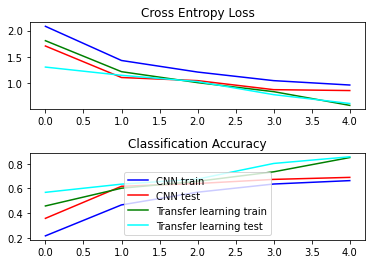

In [19]:
# plot loss - VGG16 - fixed weights
# plt.subplot(211)
# plt.title('Cross Entropy Loss')
# plt.plot(history.history['loss'], color='blue', label='train')
# plt.plot(history.history['val_loss'], color='red', label='test')
# #plt.ylim(0,2)
# # plot accuracy
# plt.subplot(212)
# plt.title('Classification Accuracy')
# plt.plot(history.history['accuracy'], color='blue', label='train')
# plt.plot(history.history['val_accuracy'], color='red', label='test')
# #plt.ylim(0,1)
# # add legend
# plt.legend()
# # Tweak spacing between subplots to prevent labels from overlapping
# plt.subplots_adjust(hspace=0.5)


# plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(CNN_history.history['loss'], color='blue', label='CNN train')
plt.plot(CNN_history.history['val_loss'], color='red', label='CNN test')
plt.plot(TL_history_VGG1.history['loss'], color='green', label='Transfer learning VGG16 train')
plt.plot(TL_history_VGG1.history['val_loss'], color='cyan', label='Transfer learning VGG16 test')
plt.grid
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(CNN_history.history['accuracy'], color='blue', label='CNN train')
plt.plot(CNN_history.history['val_accuracy'], color='red', label='CNN test')
plt.plot(TL_history_VGG1.history['accuracy'], color='green', label='Transfer learning VGG16 train')
plt.plot(TL_history_VGG1.history['val_accuracy'], color='cyan', label='Transfer learning VGG16 test')
# plt.ylim(0,2)
# plt.ylim(0,1)
# add legend
plt.legend()
# Tweak spacing between subplots to prevent labels from overlapping
plt.grid
plt.subplots_adjust(hspace=0.5)

## Comparing CNN with VGG16 Transfer learning model with fixed weights
- The cross entropy loss of transfer learning model is lower than the CNN model
- Classification accuracy of Transfer learning model is better than CNN
- The learning rate (slope of the cross entropy loss curve) of Transfer learning model is higher than the CNN model
- Difference in architecture
-- For CNN
--- Total params: 440,090
--- Trainable params: 440,090
---  Non-trainable params: 0
-- For Transfer learning with VGG16
--- Total params: 14,920,708
--- Trainable params: 206,020
--- Non-trainable params: 14,714,688
- The trainable parameters for Transfer learning model are less because of fixed weights, but it performs better than the CNN model
- Tha advantage of Transfer learning model is that it is optimized by a larger dataset and hence the weights are more accurate. Another advantage of Trnsfer learning model is that it  take lesser time than the CNN model due to lesser amount of trainable parameters

In [21]:
# ResNet50 - fixed weights
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(64, 64, 3))
for layer in model.layers:
	layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu')(flat1)
class2 = Dense(10, activation='relu')(class1)
output = Dense(10, activation='softmax')(class2)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

batch_size = 128 # number of samples processed before the model is updated
num_epochs = 5  # number of complete passes through the training dataset before the training stops

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

history = model.fit(x=ds_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=ds_val)
print('Training complete')
TL_history_RN1 = history

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

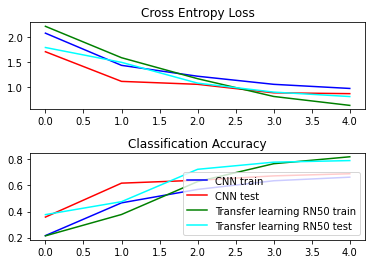

In [22]:
# plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(CNN_history.history['loss'], color='blue', label='CNN train')
plt.plot(CNN_history.history['val_loss'], color='red', label='CNN test')
plt.plot(TL_history_RN1.history['loss'], color='green', label='Transfer learning RN50 train')
plt.plot(TL_history_RN1.history['val_loss'], color='cyan', label='Transfer learning RN50 test')
plt.grid
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(CNN_history.history['accuracy'], color='blue', label='CNN train')
plt.plot(CNN_history.history['val_accuracy'], color='red', label='CNN test')
plt.plot(TL_history_RN1.history['accuracy'], color='green', label='Transfer learning RN50 train')
plt.plot(TL_history_RN1.history['val_accuracy'], color='cyan', label='Transfer learning RN50 test')
# plt.ylim(0,2)
# plt.ylim(0,1)
# add legend
plt.legend()
# Tweak spacing between subplots to prevent labels from overlapping
plt.grid
plt.subplots_adjust(hspace=0.5)

## Comparing CNN with ResNet50 Transfer learning model with fixed weights
- The results look similar to the VGG16 model
- The cross entropy loss of transfer learning model is lower than the CNN model
- Classification accuracy of Transfer learning model is better than CNN
- The learning rate (slope of the cross entropy loss curve) of Transfer learning model is higher than the CNN model
- Difference in architecture
-- For CNN
--- Total params: 440,090
--- Trainable params: 440,090
---  Non-trainable params: 0
-- For Transfer learning with VGG16
--- Total params: 14,920,708
--- Trainable params: 206,020
--- Non-trainable params: 14,714,688
- The trainable parameters for Transfer learning model are less because of fixed weights, but it performs better than the CNN model
- Tha advantage of Transfer learning model is that it is optimized by a larger dataset and hence the weights are more accurate. Another advantage of Trnsfer learning model is that it  take lesser time than the CNN model due to lesser amount of trainable parameters

In [23]:
# ResNet50 - full
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(64, 64, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu')(flat1)
class2 = Dense(10, activation='relu')(class1)
output = Dense(10, activation='softmax')(class2)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

batch_size = 128 # number of samples processed before the model is updated
num_epochs = 5  # number of complete passes through the training dataset before the training stops

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

history = model.fit(x=ds_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=ds_val)
print('Training complete')
TL_history_RN2 = history

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

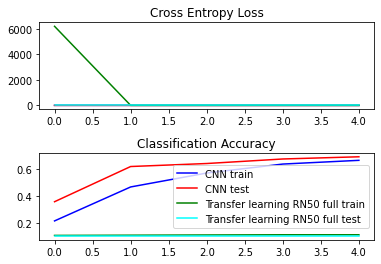

In [24]:
# plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(CNN_history.history['loss'], color='blue', label='CNN train')
plt.plot(CNN_history.history['val_loss'], color='red', label='CNN test')
plt.plot(TL_history_RN2.history['loss'], color='green', label='Transfer learning RN50 full train')
plt.plot(TL_history_RN2.history['val_loss'], color='cyan', label='Transfer learning RN50 full test')
plt.grid
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(CNN_history.history['accuracy'], color='blue', label='CNN train')
plt.plot(CNN_history.history['val_accuracy'], color='red', label='CNN test')
plt.plot(TL_history_RN2.history['accuracy'], color='green', label='Transfer learning RN50 full train')
plt.plot(TL_history_RN2.history['val_accuracy'], color='cyan', label='Transfer learning RN50 full test')
# plt.ylim(0,2)
# plt.ylim(0,1)
# add legend
plt.legend()
# Tweak spacing between subplots to prevent labels from overlapping
plt.grid
plt.subplots_adjust(hspace=0.5)

## Comparing CNN with fully trainable ResNet50 Transfer learning model
- The cross entropy loss of transfer learning model is much higher than the CNN model
- Classification accuracy of Transfer learning model is also not better than CNN
- The learning rate (slope of the cross entropy loss curve) of Transfer learning model is decent but loss is still higher since the loss curve reaches a stagnant value after several epochs
- Difference in architecture
-- For CNN
--- Total params: 440,090
--- Trainable params: 440,090
---  Non-trainable params: 0
-- For Transfer learning with VGG16
--- Total params: 14,920,708
--- Trainable params: 14,920,708
--- Non-trainable params: 0
- The number trainable parameters for Transfer learning model are very high
- Fully trainable model take longer time to finish than the CNN model of the fixed weight model. Bad trade-off since the accuracy is also not good.

# Q4: instance segmentation using a U-net

In step 4, we ask you to do a U-net classification on a set of [Landsat-8 imagery downloaded from the Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=en). The data can be found on Brightspace in the Assignment Data section of `Content/week 7`. It contains of a tensorflow datarecord format which can be read using the following preprocessing (which you should not worry about for this assignment)

In [ ]:
# Specify inputs (Landsat bands) to the model and the response variable.
opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
thermalBands = ['B10', 'B11']
BANDS = opticalBands + thermalBands
RESPONSE = 'impervious'
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

In [ ]:
def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURES]
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]


def get_dataset(pattern):
  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
  Returns:
    A tf.data.Dataset
  """
  glob = tf.io.gfile.glob(pattern)
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset

BUFFER_SIZE = 2000
BATCH_SIZE = 16

To load the data, you just need to specify the correct folder/filename in colab. We recommend to mount your google drive (where you can store the data) to easily load the data:

In [ ]:
# this mounts your Google Drive to the Colab VM and will ask you to authenticate
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# For training
gdrive_filename_training = '/content/drive/MyDrive/fcnn-demo-SL_eval_patches_g0.tfrecord.gz'
dataset = get_dataset(gdrive_filename_training)
training = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# For evaluation
gdrive_filename_training = '/content/drive/MyDrive/fcnn-demo-SL_training_patches_g0.tfrecord.gz'
dataset = get_dataset(gdrive_filename_training)
validation = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

You can now load and visualize that data (e.g. band 3 ([Band 3 (green) surface reflectance](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=en#bands)) or the RGB bands which are bands 1:4 in reversed order as the satellite gives us BGR and we need RGB) with:

In [ ]:
temp = training.take(1).as_numpy_iterator()

In [ ]:
for i in temp:
  im = i[0][0][:,:,:]
  rgb = np.flip(i[0][0][:,:,1:4],axis=2) # take band 1:4 and flip it from BGR to RGB
  lb = i[1][0][:,:,0]

In [ ]:
  fig, axs = plt.subplots(1,2,figsize=(15,5))
  i1 = axs[0].imshow(rgb*10)
  axs[0].set_title('RGB')
  i2= axs[1].imshow(lb)
  axs[1].set_title('Imperviousness')
  plt.colorbar(i1)

## Q4.1: homemade U-net

 * `[code]` build a U-net to these Landsat images for imperviousness during 5 epochs. You can copy the structure of the example notebook.
 * `[code]` make a plot with two subpanels that shows the loss (panel 1) and RMSE (panel 2) for U-net
 * `[code]` plot some images (e.g. 5) with the true and predicted label to illustrate the performance of the model
 * `[text]` shortly (max 5 sentences) explain which loss function you implemented for training the network and why

As you will see, the performance of the model will be sub-optimal as you would need a lot of epochs and computing power to get good results and this is beyond the goal of the assignment. Therefore, we have also provided a pre-trained model (50 epochs. 25 hours. final RMSE ~0.08), which you can use for predictions right away. You can load the model, which is also in the `Assignment Data section of Content/week 7`:

In [ ]:
m = tf.keras.models.load_model('geemm.h5')

## Q4.2: pre-trained U-net
* `[code]` use the pre-trained model to predict the imperviousness of the validation dataset
* `[code]` plot some images (e.g. 5) with the true and predicted label to illustrate the performance of the model
* `[text]` shortly discuss the performance of the model based on these example images (e.g., where does it seem to be ok, where not, why could that be the case)

# End
I hope you enjoy the assignment. In case of questions, please use the mattermost channel of week 7.